In [1]:
#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Performance Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#For Bagging implementation
from sklearn.ensemble import BaggingClassifier

#For AdaBoost implementation
from sklearn.ensemble import AdaBoostClassifier

#for Navie Bayes

from sklearn.naive_bayes import BernoulliNB

#SMOTE
from imblearn.over_sampling import SMOTE

#GridSearchCV
from sklearn.model_selection import GridSearchCV



In [2]:
from google.colab import files
uploaded = files.upload()

Saving insurance_claims.csv to insurance_claims.csv


In [14]:
# Read from CSV file
df = pd.read_csv('insurance_claims.csv')
df.sample(5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
126,166,38,414779,9/11/92,IL,100/300,2000,1588.55,0,435758,...,?,40320,5760,5760,28800,Suburu,Impreza,2001,N,NaN
885,254,45,633375,17/9/03,IL,250/500,500,1083.64,0,614372,...,?,79680,13280,13280,53120,BMW,3 Series,2004,N,NaN
194,73,26,918777,4/4/03,IL,250/500,2000,1191.19,4000000,468813,...,YES,40160,5020,0,35140,Chevrolet,Tahoe,2003,N,NaN
971,79,25,732169,5/11/00,OH,500/1000,500,1863.04,0,462698,...,?,67800,13560,6780,47460,Mercedes,C300,1995,N,NaN
785,257,40,463237,9/2/00,IN,100/300,2000,1306.00,0,610381,...,?,50050,7700,3850,38500,Ford,Fusion,2008,Y,NaN


# Exploratory Data Analysis

### Find Missing Values
Performing a quick exploration, using the pandas `.isnull()` function, we see there are no empty variables. However, we realised that there are some rows filled with "?" in some of their columns when we did a `df.sample(5)`. We quickly identified that there are 178 records in `collision_type`, 360 records in `property_damage` and 343 records in `police_report_available` that contains `?` in their columns.

In [15]:
df.isnull().sum() # Returns no null values
result = []
columns_head = []
for col in df.columns:
    if "?" in df[col].values:
        result.append(col)

print("Columns that have ? in their records:")
print(pd.Series(result),"\n")

print("No. of '?' in collision_type:", df[df["collision_type"] == "?"]["collision_type"].count())
print("No. of '?' in property_damage:", df[df["property_damage"] == "?"]["property_damage"].count())
print("No. of '?' in police_report_available:", df[df["police_report_available"] == "?"]["collision_type"].count())

Columns that have ? in their records:
0             collision_type
1            property_damage
2    police_report_available
dtype: object 

No. of '?' in collision_type: 178
No. of '?' in property_damage: 360
No. of '?' in police_report_available: 343


<ipython-input-15-b0549545a245>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "?" in df[col].values:


### Plot Histogram
Plot a histogram to see all the numerical data in the dataset.

array([[<Axes: title={'center': 'months_as_customer'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'policy_number'}>,
        <Axes: title={'center': 'policy_deductable'}>],
       [<Axes: title={'center': 'policy_annual_premium'}>,
        <Axes: title={'center': 'umbrella_limit'}>,
        <Axes: title={'center': 'insured_zip'}>,
        <Axes: title={'center': 'capital-gains'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'incident_hour_of_the_day'}>,
        <Axes: title={'center': 'number_of_vehicles_involved'}>,
        <Axes: title={'center': 'bodily_injuries'}>],
       [<Axes: title={'center': 'witnesses'}>,
        <Axes: title={'center': 'total_claim_amount'}>,
        <Axes: title={'center': 'injury_claim'}>,
        <Axes: title={'center': 'property_claim'}>],
       [<Axes: title={'center': 'vehicle_claim'}>,
        <Axes: title={'center': 'auto_year'}>,
        <Axes: title={'center': '_c39'}>, <Axes: 

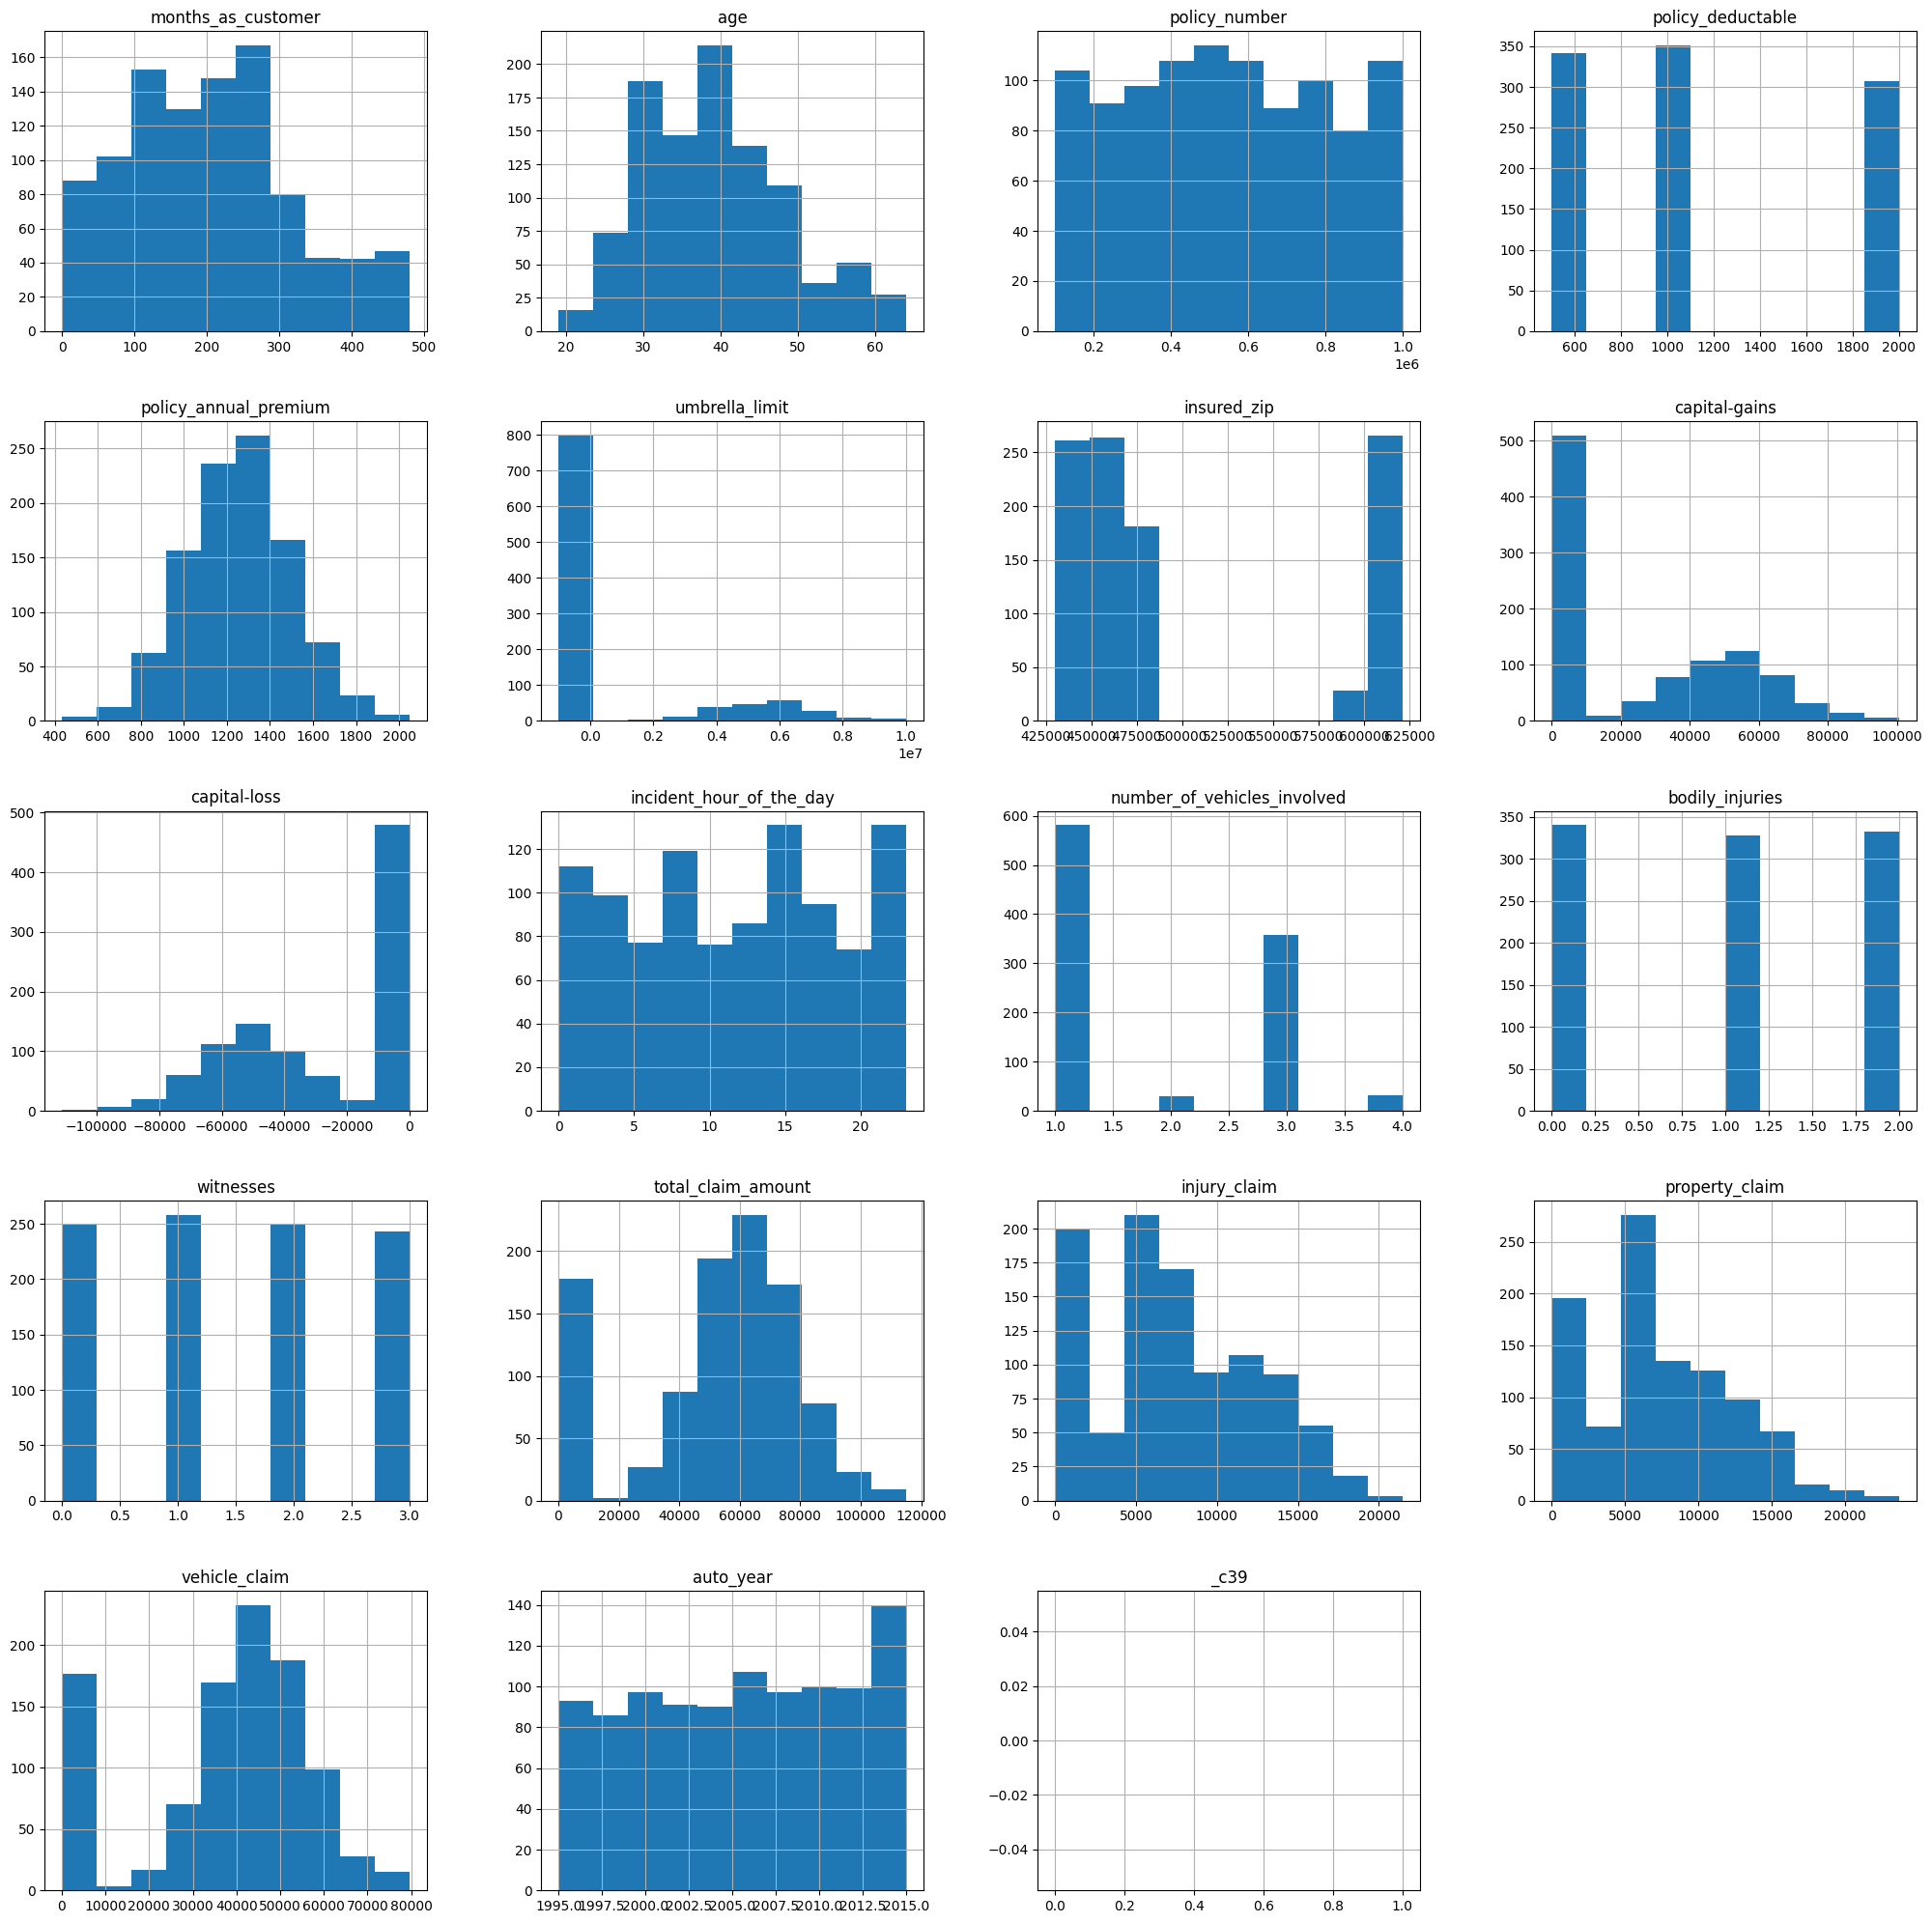

In [16]:
df.hist(figsize=(25,25))


### Identify number of unique values in each column
We will be dropping the columns that have high number of distinct values and/or columns that does not fit into our business context use case. `policy_number`, `policy_bind_date`, `insured_zip`, `incident_date`, `incident_location`, `_c39`.

In [17]:
num_unique = []
for col in df.columns:
    num_unique.append(df[col].nunique())

print(pd.Series(num_unique, index = df.columns))

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

# Feature Selection / Handling Categorical Variables

| Features Dropped | Reason |
| ----------- | ----------- |
| `_c39`, `incident_date` | Doesn't provide useful information |
| `policy_number`, `policy_bind_date`, `insured_zip`, `incident_location` | Too many distinct values in each columns (1000, 951, 995, 1000) respectively |
| `injury_claim`, `property_claim`, `vehicle_claim` | High correlation (> 0.81). All 3 combined is the same as `total_claim` |

In [18]:
# drop all identified columns
drop_columns = ["_c39", "incident_date", "policy_number", "policy_bind_date", "insured_zip", "incident_location"]
df.drop(columns=drop_columns,inplace=True)
df


,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,500/1000,1000,1310.80,0,FEMALE,Masters,craft-repair,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,IL,100/300,1000,1436.79,0,FEMALE,PhD,prof-specialty,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,OH,250/500,500,1383.49,3000000,FEMALE,Masters,armed-forces,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,IL,500/1000,2000,1356.92,5000000,MALE,Associate,handlers-cleaners,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [19]:
# get object columns into list
df_col = list(df.select_dtypes(include=['object']).columns)

# creating instance of labelencoder
labelencoder = LabelEncoder()

# loop through df_col object list
for col in df_col:
    new_col = col + "_encode"
    # Assigning numerical values and storing in another column
    df[new_col] = labelencoder.fit_transform(df[col])


In [20]:
# drop not encoded columns
df.drop(columns=df_col, inplace=True)
df.shape

(1000, 34)

In [21]:
# drop correlated columns ('injury_claim', 'property_claim', 'vehicle_claim')
# correlation > 0.81 and the 3 cols == total claim
df.drop(columns=['injury_claim', 'property_claim', 'vehicle_claim'], inplace=True)
df.shape

(1000, 31)

### Visualising the Features
We will then take a look at all the columns as well as the columns we have encoded.

In [22]:
df

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,...,collision_type_encode,incident_severity_encode,authorities_contacted_encode,incident_state_encode,incident_city_encode,property_damage_encode,police_report_available_encode,auto_make_encode,auto_model_encode,fraud_reported_encode
0,328,48,1000,1406.91,0,53300,0,5,1,1,...,3,0,4,4,1,2,2,10,1,1
1,228,42,2000,1197.22,5000000,0,0,8,1,0,...,0,1,4,5,5,0,0,8,12,1
2,134,29,2000,1413.14,5000000,35100,0,7,3,2,...,2,1,4,1,1,1,1,4,30,0
3,256,41,2000,1415.74,6000000,48900,-62400,5,1,1,...,1,0,4,2,0,0,1,3,34,1
4,228,44,1000,1583.91,6000000,66000,-46000,20,1,0,...,0,1,2,1,0,1,1,0,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,1000,1310.80,0,0,0,20,1,0,...,1,1,1,0,4,2,0,6,6,0
996,285,41,1000,1436.79,0,70900,0,23,1,2,...,2,0,1,4,3,2,0,13,28,0
997,130,34,500,1383.49,3000000,35100,0,4,3,2,...,3,1,4,0,0,0,2,11,19,0
998,458,62,2000,1356.92,5000000,0,0,2,1,0,...,2,0,3,1,0,0,2,1,5,0


### Correlation with Target Variable: `fraud_reported_encoded`
We will then plot a correlation heatmap between all the various features and see how highly correlated they are with the target feature `fraud_reported_encoded`. We then pick select the features that have a correlation absolute value of `>= 0.05`, since the model shouldn't be affected by how negatively or positively correlated these features are with the target feature, so long it is highly correlated (above our set treshold of `>= 0.05`).


<Axes: >

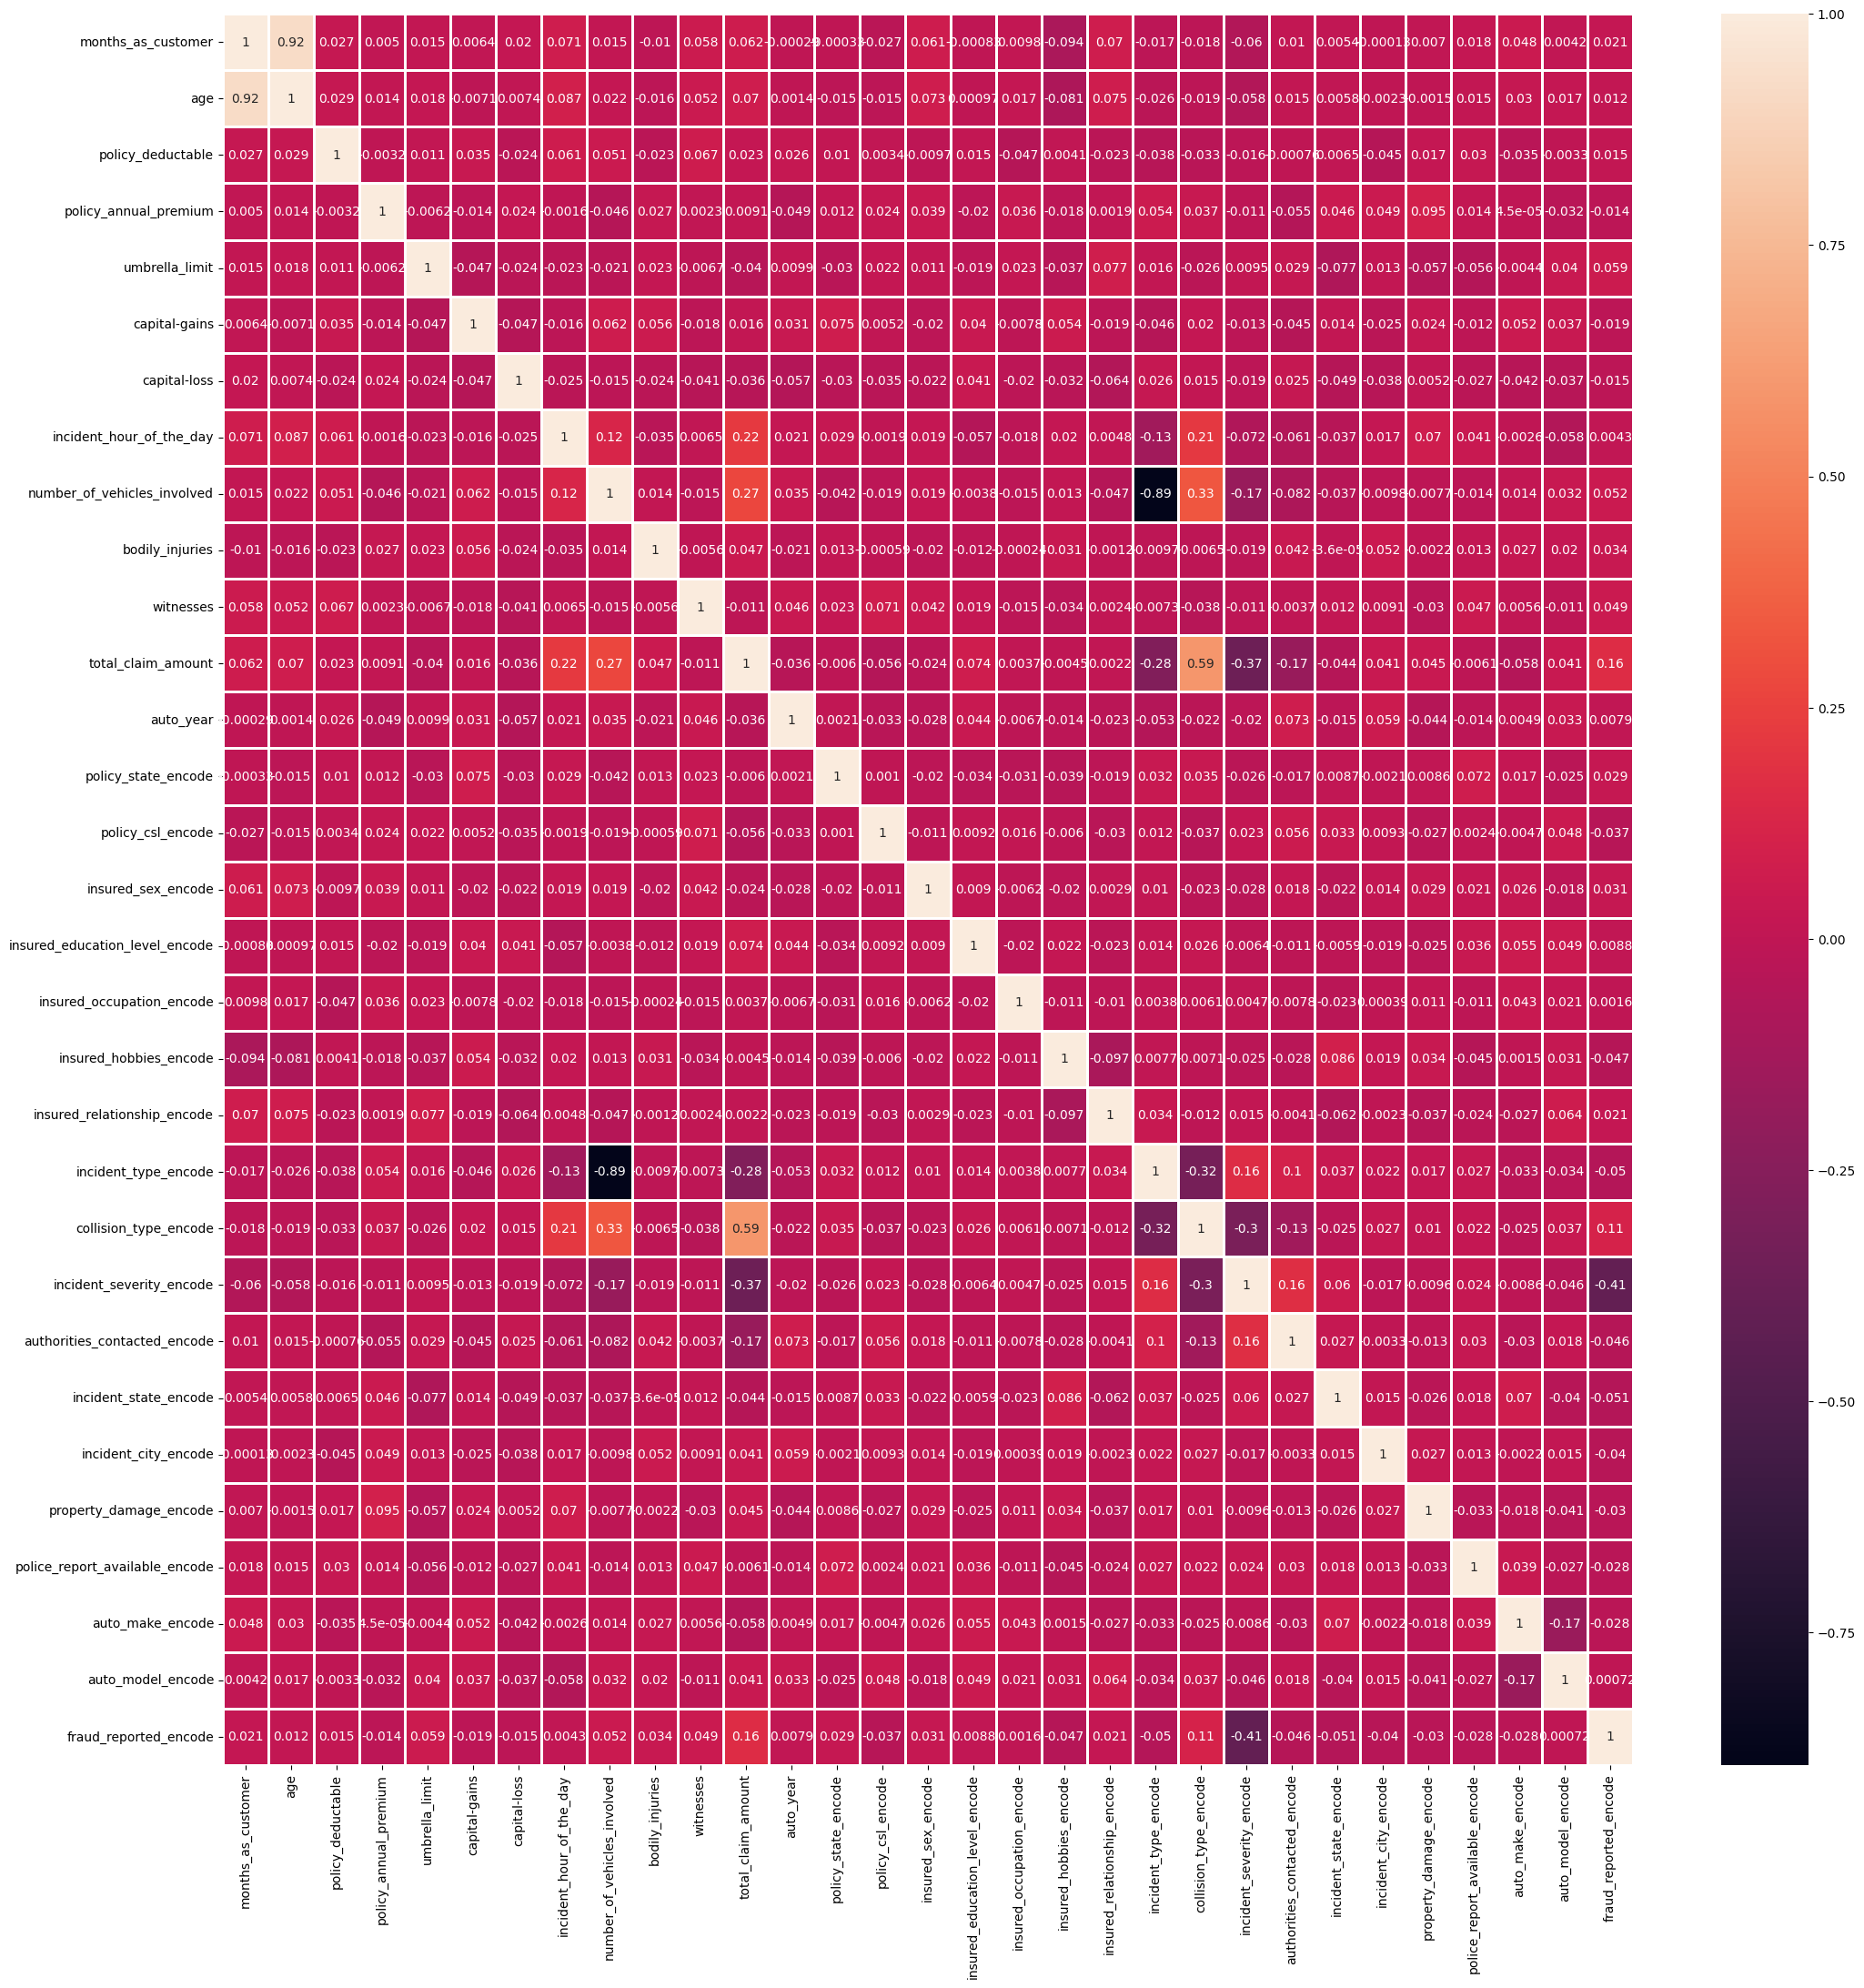

In [23]:
plt.figure(figsize=(25,25))
corr=df.corr()
sns.heatmap(data=corr,annot=True,fmt='.2g',linewidth=1)

In [24]:
fraud_corr_val = df.corr()["fraud_reported_encode"].sort_values().abs()
fraud_corr_val.between(0.05,1.0)

incident_severity_encode           True
incident_state_encode              True
incident_type_encode               True
insured_hobbies_encode            False
authorities_contacted_encode      False
incident_city_encode              False
policy_csl_encode                 False
property_damage_encode            False
police_report_available_encode    False
auto_make_encode                  False
capital-gains                     False
capital-loss                      False
policy_annual_premium             False
auto_model_encode                 False
insured_occupation_encode         False
incident_hour_of_the_day          False
auto_year                         False
insured_education_level_encode    False
age                               False
policy_deductable                 False
months_as_customer                False
insured_relationship_encode       False
policy_state_encode               False
insured_sex_encode                False
bodily_injuries                   False


### Check for Multicollinearity

If the VIF is greater than 10, multicolinearity is likely present between the features and we should consider dropping the variable. Thankfully, none of our variables have a VIF value greater than 10.


In [25]:
!pip install statsmodels==0.13.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# extract out our target feature and features for the model
features_selected = ["incident_severity_encode", "incident_state_encode", "incident_type_encode", "number_of_vehicles_involved", "umbrella_limit", "collision_type_encode", "total_claim_amount"]
X = df[features_selected]
y = df["fraud_reported_encode"]

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df2 = df[features_selected]
vif = pd.DataFrame()
vif["features"] = features_selected
vif["vif_Factor"] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
vif

,features,vif_Factor
0,incident_severity_encode,2.751382
1,incident_state_encode,3.151465
2,incident_type_encode,3.039501
3,number_of_vehicles_involved,6.366314
4,umbrella_limit,1.226129
5,collision_type_encode,5.615095
6,total_claim_amount,7.624006


In [33]:
X[['total_claim_amount']].max()

total_claim_amount    114920
dtype: int64

# Model

### Split into Training and Testing sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling Continuous Variables
As the features `umbrella_limit` and `total_claim_amount` are both continuous variables containing huge range of values that may influence the model, we have to first scale these variables and pass it back to the `X_train` and `X_test` before using it in our logistic regression model.

Also, the scaling should only be performed after the data has been split into `training` and `testing`. As the test set is assuming the role of "freshly unseen data", it should not be accessible at the training stage. Therefore, we will be using `.fit_transform` for the training set and `.transform` for the testing set.

https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models

In [29]:
numerical_cols = ["umbrella_limit", "total_claim_amount"]
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [30]:
num_zeros = X_train.isin([0]).sum()
print(num_zeros)

incident_severity_encode       215
incident_state_encode           81
incident_type_encode           325
number_of_vehicles_involved      0
umbrella_limit                   0
collision_type_encode          141
total_claim_amount               0
dtype: int64


<h1>Model Training


Base Model - Bernoulli Naive Bayes

In [ ]:
#Initialize or define the model
clf = BernoulliNB()

#Fit the training feature Xs and training label Ys
clf.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = clf.predict(X_test)


#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


In [ ]:

from sklearn.naive_bayes import GaussianNB
#Initialize or define the model
clf = GaussianNB()

#Fit the training feature Xs and training label Ys
clf.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = clf.predict(X_test)


#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 22  33]]
Recall: 0.6
Precision: 0.5689655172413793
Accuracy: 0.765
F-Score: 0.584070796460177


Base Model with GridSearchCV

In [ ]:

from sklearn.naive_bayes import MultinomialNB
#Initialize or define the model
clf = MultinomialNB()

#Fit the training feature Xs and training label Ys
clf.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = clf.predict(X_test)


#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

ValueError: ignored

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'binarize': np.linspace(0.0, 1.0, 11)
}

# Create a Gaussian Naive Bayes model
clf = BernoulliNB()

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5)


# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)


print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))


Best hyperparameters: {'alpha': 0.001, 'binarize': 0.0}
Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Will use best param alpha=0.001 and binarize=0 for BernoulliNB in the codes below

Base Model + Bagging

In [ ]:
#Naive Bayes
clf = BernoulliNB(alpha=0.001,binarize=0)

# Define the BaggingClassifier
bagging = BaggingClassifier(estimator=clf, random_state=42, n_estimators=50)

# Fit the GridSearchCV object to the data
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)

#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Base Model + Bagging with GridSearchCV

In [ ]:
#Naive Bayes
clf = BernoulliNB(alpha=0.001,binarize=0)

# Define the BaggingClassifier
bagging = BaggingClassifier(estimator=clf, random_state=42, n_estimators=50)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [10,50,100]
}

# Define the GridSearchCV object
grid_search = GridSearchCV(
    estimator=bagging, param_grid=param_grid, cv=5, n_jobs=-1
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Best hyperparameters: {'n_estimators': 100}
Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Will use best param n_estimators=100 for bagging in the codes below

Base Model + Boosting

In [ ]:
# Define the base estimator
base_estimator = BernoulliNB(alpha=0.001,binarize=0)

# Define the AdaBoostClassifier
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=42)


# Fit the GridSearchCV object to the data
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))


Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Base Model + Boosting with GridSearchCV

In [ ]:
# Define the base estimator
base_estimator = BernoulliNB(alpha=0.001,binarize=0)

# Define the AdaBoostClassifier
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1]
}

# Define the GridSearchCV object
grid_search = GridSearchCV(
    estimator=adaboost, param_grid=param_grid, cv=5, n_jobs=-1
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))


Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 10}
Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Will use best param n_estimators=10, learning_rate=0.1 for boosting in the codes below

Base Model with Bagging + Boosting with Best Parameters

In [ ]:
# Create the base estimator
clf = BernoulliNB(alpha=0.001,binarize=0)

# Create the BaggingClassifier
bagging = BaggingClassifier(
    estimator=clf, 
    random_state=42,
    n_estimators=100
)

# Create the AdaBoostClassifier
adaboost = AdaBoostClassifier(
    estimator=bagging, 
    random_state=42, 
    learning_rate=0.1,
    n_estimators=10
)


# Fit the GridSearchCV object to the data
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))


Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


# Performing SMOTE Oversampling Technique
As our dataset is unbalanced, we will be performing SMOTE oversampling technique to increase the number of cases in our dataset in a more balanced way.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
!pip install imblearn==0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Split into Training and Testing sets

As an equally distributed classes in our `testing` set doesn't make sense as it does not replicate a real life situation of fraud detection, we will only be performing the SMOTE technique on our `training` set. The `testing` set is purely used only for testing of the performance of our model. 

https://www.kaggle.com/questions-and-answers/206597

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# define pipeline
# random_state is removed to test the performace of the model, but can be added back after finding the best

over_4060 = SMOTE(sampling_strategy=0.4) 
# oversample the minority class to have 40 percent the number of examples of the majority class

over_5050 = SMOTE() 
# oversample the minority class to have 50 percent the number of examples of the majority class

# !!! Should not be undersampling because of insufficient data points
# under = RandomUnderSampler(sampling_strategy=0.4)
# random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class

# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)
# transform the dataset

X_train, y_train = over_5050.fit_resample(X_train, y_train)


### Scaling Continuous Variables 

In [ ]:
numerical_cols = ["umbrella_limit", "total_claim_amount"]
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

<h2>Model Training

<h4>Base model with SMOTE

In [ ]:
#Initialize or define the model
clf = BernoulliNB(alpha=0.001,binarize=0)

#Fit the training feature Xs and training labestl Ys
clf.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = clf.predict(X_test)

#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


<h4>Base model with SMOTE + Bagging with Best Parameters

In [ ]:
#Naive Bayes
clf = BernoulliNB(alpha=0.001,binarize=0)

# Define the BaggingClassifier
bagging = BaggingClassifier(estimator=clf, random_state=42, n_estimators=100)

#Fit the training feature Xs and training labestl Ys
bagging.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = bagging.predict(X_test)

#Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test,y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


<h4>Base model with SMOTE + Boosting with Best Parameters

In [ ]:
# Define the base estimator
clf = BernoulliNB(alpha=0.001,binarize=0)

# Define the AdaBoostClassifier
adaboost = AdaBoostClassifier(estimator=clf, random_state=42, learning_rate=0.1, n_estimators=10)

#Fit the training feature Xs and training labestl Ys
adaboost.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = adaboost.predict(X_test)
# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Base Model with SMOTE + Bagging + Boosting with Best Parameters


In [ ]:
# Create the base estimator
clf = BernoulliNB(alpha=0.001,binarize=0)

# Create the BaggingClassifier
bagging = BaggingClassifier(
    estimator=clf, 
    random_state=42,
    n_estimators=100
)

# Create the AdaBoostClassifier
adaboost = AdaBoostClassifier(
    estimator=bagging, 
    random_state=42, 
    learning_rate=0.1,
    n_estimators=10
)

#Fit the training feature Xs and training labestl Ys
adaboost.fit(X_train, y_train)

#Use the trained model to predict the test data
y_pred = adaboost.predict(X_test)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F-Score: ' + str(f1_score(y_test, y_pred)))

Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


<h1>Stacking other models on top of Base Model

Random Forest on Base Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Initialize or define the model
bnb = BernoulliNB(alpha=0.001,binarize=0)

#Fit the training feature Xs and training labestl Ys
bnb.fit(X_train, y_train)
# Use the trained Bernoulli Naive Bayes classifier to obtain the predicted probabilities
y_pred_train = bnb.predict_proba(X_train)

# Train a Random Forest classifier using the predicted probabilities as input features
rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rfc.fit(y_pred_train, y_train)

# Use the trained Random Forest classifier to make predictions on the test set
y_pred_test_bnb = bnb.predict_proba(X_test)
y_pred_test = rfc.predict(y_pred_test_bnb)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_test))
print('Recall: ' + str(recall_score(y_test, y_pred_test)))
print('Precision: ' + str(precision_score(y_test, y_pred_test)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_test)))
print('F-Score: ' + str(f1_score(y_test, y_pred_test)))

Confusion Matrix: 
[[119  26]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5806451612903226
Accuracy: 0.775
F-Score: 0.6153846153846153


Logistic Regression on Base Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train the BernoulliNB model
bernoulli = BernoulliNB()
bernoulli.fit(X_train, y_train)

# Use the BernoulliNB model to predict the target variable for the test set
y_pred_train = bernoulli.predict(X_train)
y_pred_test = bernoulli.predict(X_test)

# Concatenate the predicted target variable with the original features
X_train_new = np.concatenate((X_train, y_pred_train.reshape(-1, 1)), axis=1)
X_test_new = np.concatenate((X_test, y_pred_test.reshape(-1, 1)), axis=1)

# Train the logistic regression model on the new dataset
logistic = LogisticRegression()
logistic.fit(X_train_new, y_train)

# Use the logistic regression model to predict the target variable for the test set
y_pred = logistic.predict(X_test_new)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_test))
print('Recall: ' + str(recall_score(y_test, y_pred_test)))
print('Precision: ' + str(precision_score(y_test, y_pred_test)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_test)))
print('F-Score: ' + str(f1_score(y_test, y_pred_test)))



Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


Decision Tree on Base Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train the BernoulliNB model
bernoulli = BernoulliNB()
bernoulli.fit(X_train, y_train)

# Use the BernoulliNB model to predict the target variable for the test set
y_pred_train = bernoulli.predict(X_train)
y_pred_test = bernoulli.predict(X_test)

# Concatenate the predicted target variable with the original features
X_train_new = np.concatenate((X_train, y_pred_train.reshape(-1, 1)), axis=1)
X_test_new = np.concatenate((X_test, y_pred_test.reshape(-1, 1)), axis=1)

# Train the Decision Tree classifier on the new dataset
dt = DecisionTreeClassifier()
dt.fit(X_train_new, y_train)

# Use the Decision Tree classifier to predict the target variable for the test set
y_pred = dt.predict(X_test_new)

# Print the accuracy, precision, recall, and F1 score of the result
# create confusion matrix
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_test))
print('Recall: ' + str(recall_score(y_test, y_pred_test)))
print('Precision: ' + str(precision_score(y_test, y_pred_test)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_test)))
print('F-Score: ' + str(f1_score(y_test, y_pred_test)))


Confusion Matrix: 
[[120  25]
 [ 19  36]]
Recall: 0.6545454545454545
Precision: 0.5901639344262295
Accuracy: 0.78
F-Score: 0.6206896551724138


<h1>Results

Best Model without SMOTE - Base Model:<br>
Confusion Matrix: <br>
[[120  25]<br>
 [ 22  33]]<br>
Recall: 0.6<br>
Precision: 0.5689655172413793<br>
Accuracy: 0.765<br>
F-Score: 0.584070796460177

Best Model with SMOTE - Base Model with Bagging and Boosting with best parameters: <br>
Confusion Matrix: <br>
[[118  27] <br>
 [ 22  33]] <br>
Recall: 0.6 <br>
Precision: 0.55 <br>
Accuracy: 0.755 <br>
F-Score: 0.5739130434782609

Overall Best Model - Base Model:<br>
Confusion Matrix: <br>
[[120  25]<br>
 [ 22  33]]<br>
Recall: 0.6<br>
Precision: 0.5689655172413793<br>
Accuracy: 0.765<br>
F-Score: 0.584070796460177